# **Project: Plant Seedlings Classification**



### **Context:**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.




### **Objective:**

The aim of this project is to **use a deep learning model to classify plant seedlings through supervised learning.**


### **Data Description:**
The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species at several growth stages.**

You are provided with a dataset of images of plant seedlings at various stages of growth.

- Each image has a filename that is its unique id.
- The dataset comprises 12 plant species.
- The goal of the project is to create a classifier capable of determining a plant's species from a photo.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet





### **Learning Outcomes:**
- Pre-processing of image data
- Visualization of images
- Building the CNN
- Evaluating the Model






In [1]:
#pip install tensorflow

In [2]:
#pip install torchvision

## **Importing the necessary libraries**

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
from glob import glob
import itertools
import seaborn as sns
from PIL import Image

# PyTorch Modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms
from torchsummary import summary

# Sklearn Modules for Data Splitting and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Other Utilities
import warnings
warnings.filterwarnings('ignore')

# Global Variables
seed = 7
torch.manual_seed(seed)  # For reproducibility in PyTorch

# Ensure CUDA or GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

## **Reading the dataset**

In [4]:
# Load the image file of dataset
images = np.load('images.npy')

# Load the labels file of dataset
labels = pd.read_csv('Labels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels 

In [5]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 images of shape 128 x 128 each with 3 channels. Here, each image is an RGB image.

Let's plot the first 8 images 

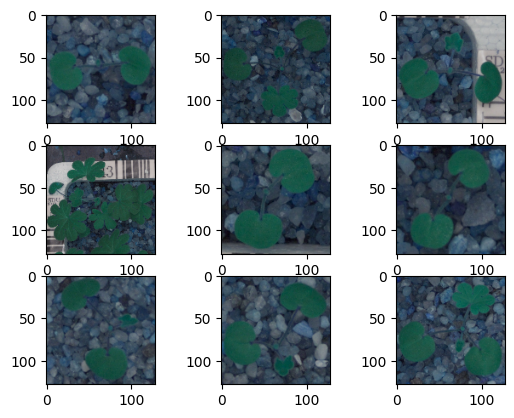

In [6]:
# Show some example images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

Let's understand if the dataset is imbalanced or not 

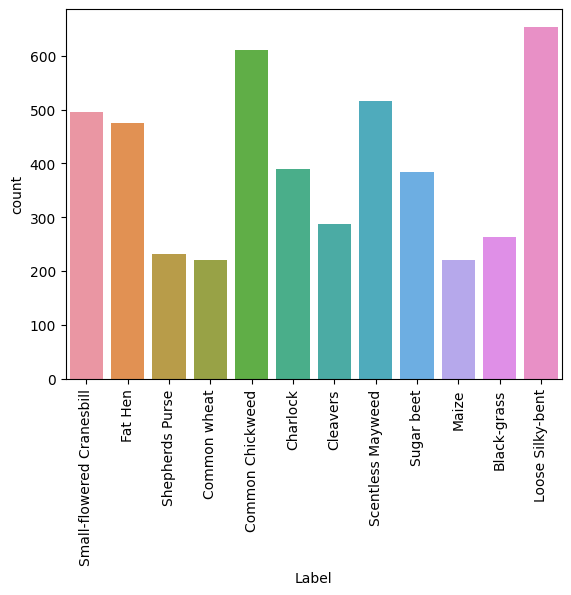

In [7]:
sns.countplot(x='Label', data=labels)
plt.xticks(rotation='vertical')
plt.show()

As you can see from the above plot, the dataset is quite balanced. But,we might need to stratify the train_test_split

## **Exploratory Data Analysis** 

### **Plotting mean images** 

In [8]:
def find_mean_image(full_mat):
    # calculate the average
    mean_image = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_image = mean_image.reshape((150,150))
  
    return mean_image


In [9]:
CATEGORIES = labels['Label'].unique()

In [10]:
d = { i:[] for i in CATEGORIES}
d

{'Small-flowered Cranesbill': [],
 'Fat Hen': [],
 'Shepherds Purse': [],
 'Common wheat': [],
 'Common Chickweed': [],
 'Charlock': [],
 'Cleavers': [],
 'Scentless Mayweed': [],
 'Sugar beet': [],
 'Maize': [],
 'Black-grass': [],
 'Loose Silky-bent': []}

In [11]:
for i in labels.index:
      gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
      gray = cv2.resize(gray,(150,150))
      d[labels['Label'][i]].append(gray)

l = []
for i in d.keys():
      l.append(find_mean_image(d[i]))

l

[array([[75.95766129, 75.66129032, 75.11290323, ..., 77.50604839,
         77.38508065, 77.58870968],
        [75.92540323, 75.92943548, 75.55443548, ..., 77.47177419,
         77.15322581, 77.12096774],
        [76.29032258, 76.24596774, 75.89919355, ..., 77.64919355,
         77.29435484, 77.01209677],
        ...,
        [75.77217742, 75.60483871, 75.75403226, ..., 78.27217742,
         78.52419355, 78.13709677],
        [75.92943548, 76.14314516, 76.29032258, ..., 78.21975806,
         78.39314516, 77.62298387],
        [75.80241935, 76.2983871 , 76.40725806, ..., 78.36290323,
         78.6108871 , 78.33266129]]),
 array([[81.60631579, 81.93263158, 81.82736842, ..., 77.26315789,
         77.25894737, 77.78526316],
        [81.59578947, 81.87368421, 81.92210526, ..., 77.37473684,
         77.28842105, 77.59157895],
        [81.37263158, 81.61684211, 81.68842105, ..., 77.24631579,
         77.2       , 77.41894737],
        ...,
        [77.99368421, 78.12631579, 78.02105263, ..., 7

In [12]:
range(len(l))

range(0, 12)

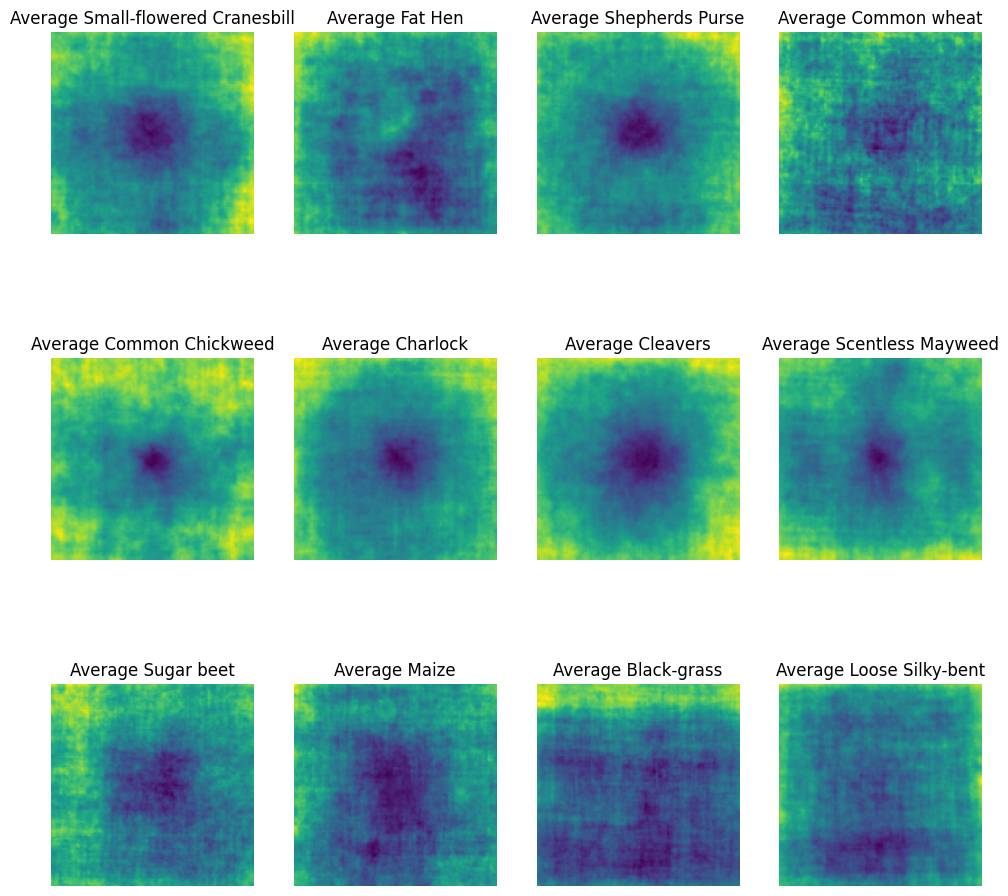

In [20]:
plt.subplots(figsize = (12,12))
for i in range(len(l)):
    plt.subplot(3,4,i + 1,title='Average '+list(d.keys())[i])
    plt.imshow(l[i])
    plt.axis('off')



* Small-flowered cranesbill, Shepherds Purse, Charlock, and Cleavers have similar kinds of shapes such as width and length of the leaves. They mostly have smaller lengths and widths.
* From the Average Fat Hen graph, we can observe that the length of the leaf is large with smaller leaf width.
* Common Wheat, Silky bent, and Blackgrass possess a similar kind of structure, their width is narrower and the length of the leaf is longer as compared to others. It's a kind of grass, not a leaf.

* Sugar beet and Maize have a similar structure where the length of the leaves is more but the width is less.
* Mayweed and Common Chickweed have a similar kind of structure, Their leaves have smaller lengths and widths comparing to the Charlock category.


## **Data Preprocessing: Image Preprocessing**

## **Apply image processing:**

It is a very important step to perform image preprocessing. Preprocessing an image is an intensive task. We will be performing the following steps in order to process the images

**Convert the RGB images into HSV**

**The HSV model** describes colors similarly to how the human eye tends to perceive color. RGB defines color in terms of a combination of primary colors. In situations where color description plays an integral role, the HSV color model is often preferred over the RGB model.

**'Hue'** represents the color, **'Saturation'** represents the amount to which that respective color is mixed with white and **'Value'** represents the amount to which that respective color is mixed with black (Gray level).

**HSV color space** is more often used in computer vision owing to its **superior performance** compared to RGB color space in varying illumination levels. Often thresholding and masking is done in HSV color space. So it is very important to know the HSV values of the color we want to filter out.

In RGB, we cannot separate color information from luminance. HSV or Hue Saturation Value is used to separate image luminance from color information.

**In this problem, color is an important factor** in identifying the plant species. Hence converting RGB TO HSV is a good idea.

**In order to remove the noise, we will have to blur the images (Gaussian Blurring)** 

**In order to remove the background, we will have to create a mask.**

Creating a mask will remove the noise. For this, we will use some Morphological transformation.

**Visualize data after pre-processing.**






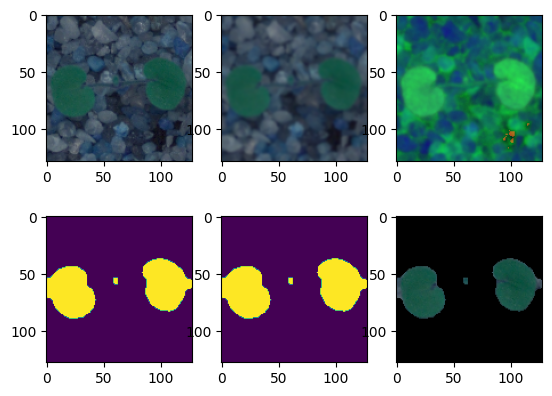

In [21]:
new_train = []
sets = []; getEx = True
for i in images:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV) #Using BGR TO HSV conversion. reason is mentioned above
    #HSV Boundaries for the Green color (GREEN PARAMETERS)
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper) # create a mask 
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)) #getting structring element ( kernal) of sie 11x11
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc) # applying morphological transformation ( closing operation ) to remove imperfections from the binary image ( mask)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i); 
        #print('ORIGINAL')
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)


CLEANED IMAGES


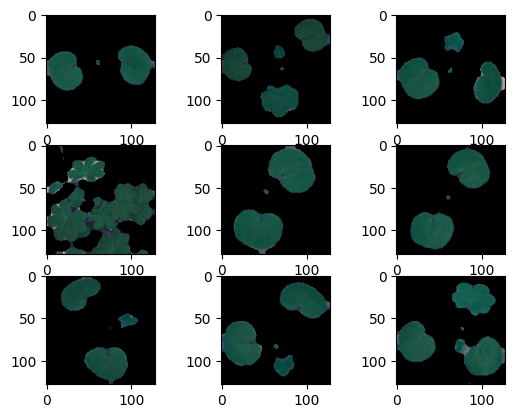

In [22]:
print("CLEANED IMAGES")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(new_train[i])

## **Making the data compatible:**

- Convert labels from digits to one hot vectors.
- Check the shape of the data. Reshape the data into shapes compatible with Keras models, if already not compatible.


In [23]:
labels.reset_index(drop=True, inplace=True)

In [24]:
# Convert string labels to integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels['Label'])

# Convert labels to PyTorch tensors
labels_encoded_tensor = torch.tensor(labels_encoded)
y = labels_encoded_tensor

In [25]:
labels_encoded_tensor

tensor([10, 10, 10,  ...,  6,  6,  6])

In [26]:
print(type(labels_encoded))
print(labels_encoded.dtype)

<class 'numpy.ndarray'>
int64


In [27]:

class PlantSeedlingDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
dataset = PlantSeedlingDataset(new_train, labels_encoded_tensor, transform=transform)

In [29]:

# Split the dataset into training and temporary (val + test) sets
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=seed,stratify=y)

# For the second split, stratify using the labels corresponding to 'temp_indices'
temp_y = [y[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=seed, stratify=temp_y)

# Create DataLoaders for each set
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(Subset(dataset, val_indices), batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(Subset(dataset, test_indices), batch_size=32, shuffle=False, num_workers=0)


## **Building the CNN:**

- Define layers.
- Set the optimizer and loss function. 

In [30]:
class PlantSeedlingCNN(nn.Module):
    def __init__(self):
        super(PlantSeedlingCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding='same')
        self.maxpool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.4)

        self.globalmaxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(128, 256)
        self.dropout4 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 12)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxpool3(x)
        x = self.dropout3(x)

        x = self.globalmaxpool(x)
        x = x.view(x.size(0), -1) # Flatten the layer
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

model = PlantSeedlingCNN().to(device)

summary(model, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
            Conv2d-2         [-1, 32, 128, 128]          25,632
         MaxPool2d-3           [-1, 32, 64, 64]               0
           Dropout-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
            Conv2d-6           [-1, 64, 64, 64]          36,928
         MaxPool2d-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10          [-1, 128, 32, 32]         147,584
        MaxPool2d-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                  [

In [31]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Lists to store accuracy per epoch
train_accuracy_list = []
val_accuracy_list = []
num_epochs = 40
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/40], Train Accuracy: 13.08%, Val Accuracy: 13.76%
Epoch [2/40], Train Accuracy: 13.44%, Val Accuracy: 13.76%
Epoch [3/40], Train Accuracy: 13.77%, Val Accuracy: 23.46%
Epoch [4/40], Train Accuracy: 24.99%, Val Accuracy: 32.72%
Epoch [5/40], Train Accuracy: 31.19%, Val Accuracy: 33.29%
Epoch [6/40], Train Accuracy: 32.69%, Val Accuracy: 35.25%
Epoch [7/40], Train Accuracy: 33.89%, Val Accuracy: 36.52%
Epoch [8/40], Train Accuracy: 35.52%, Val Accuracy: 40.59%


In [ ]:
# Save the model
torch.save(model.state_dict(), 'Plant_Seedling_Model.pth')

In [ ]:
# Testing the model
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/test_total:.4f}, Test Accuracy: {test_accuracy:.2f}%')


In [ ]:
#Plotting the training and validation accuracy:¶
plt.figure()
plt.plot(train_accuracy_list, label='train_accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### **Preventing overfitting**

Overfitting is a problem in machine learning in which our model performs very well on the training data but performs poorly on testing data.

**The problem of overfitting is more in deep learning**, since the neural network automatically detects several features and builds a complex mathematical model with several layers to map the input to the output. The tendency of deep neural networks to overfit to the training dataset could affects our end result badly, so this issue has to be addressed immediately.

There are many **regularization techniques** to overcome overfitting: 

1) Dropout

2) Data Augmentation

3) Batch normalization

We will use Data augmentation here to prevent overfitting.

Here, we are using the ImageDataGenerator() function which randomly changes the characteristics of images and provides randomness in the data.

**Reducing the Learning Rate:**

**ReduceLRonPlateau()** is a function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. 
- This may start decreasing the loss at a smaller learning rate. 
- There is a possibility that the loss may still not decrease. 
- This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

In [15]:

class PlantSeedlingDatasetv1(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]

        # Convert NumPy array to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    # Apply transformations that work on PIL images
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    # Now convert the PIL image to a Tensor
    transforms.ToTensor(),
    # Apply normalization on the tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [16]:
dataset = PlantSeedlingDatasetv1(new_train, labels_encoded_tensor, transform=transform)

In [17]:

from sklearn.model_selection import train_test_split

# Split the dataset into training and temporary (val + test) sets
train_indices, temp_indices = train_test_split(
    range(len(dataset)), test_size=0.3, random_state=seed,stratify=y)

# For the second split, stratify using the labels corresponding to 'temp_indices'
temp_y = [y[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5, random_state=seed, stratify=temp_y)

# Create DataLoaders for each set
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(Subset(dataset, val_indices), batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(Subset(dataset, test_indices), batch_size=32, shuffle=False, num_workers=0)


In [18]:

class PlantSeedlingCNNv1(nn.Module):
    def __init__(self):
        super(PlantSeedlingCNNv1, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding='same')

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)

        # Global max pooling layer
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 12)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)

        # Global max pooling
        x = self.global_max_pool(x)

        # Flatten the tensor
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)

        return x

# Create an instance of the model
model1 = PlantSeedlingCNNv1()

# Print model summary (requires additional package like torchsummary)
from torchsummary import summary
summary(model1, (3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           2,432
            Conv2d-2         [-1, 32, 128, 128]          25,632
         MaxPool2d-3           [-1, 32, 64, 64]               0
           Dropout-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
            Conv2d-6           [-1, 64, 64, 64]          36,928
         MaxPool2d-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
           Conv2d-10          [-1, 128, 32, 32]         147,584
        MaxPool2d-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
           Linear-14                  [

In [19]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.RMSprop(model1.parameters(), lr=0.001, alpha=0.9, eps=1e-08)

#optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=0.00001)


## **Data Augmentation (Regularization)**

- Data Augmentation is a strategy to significantly increase the diversity of data available for training models, without actually collecting new data.
- Data Augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks in order to help regularize them and reduce overfitting.



In [21]:

# Lists to store accuracy per epoch
train_accuracy_list = []
val_accuracy_list = []
num_epochs = 40
# Training loop
for epoch in range(num_epochs):
    model1.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracy_list.append(train_accuracy)

    # Validation phase
    model1.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_accuracy_list.append(val_accuracy)
     # Step the scheduler based on validation accuracy
    scheduler.step(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/40], Train Accuracy: 12.99%, Val Accuracy: 13.76%
Epoch [2/40], Train Accuracy: 13.11%, Val Accuracy: 13.76%
Epoch [3/40], Train Accuracy: 14.23%, Val Accuracy: 17.56%
Epoch [4/40], Train Accuracy: 25.74%, Val Accuracy: 30.34%
Epoch [5/40], Train Accuracy: 31.91%, Val Accuracy: 36.24%
Epoch [6/40], Train Accuracy: 37.53%, Val Accuracy: 42.42%
Epoch [7/40], Train Accuracy: 41.08%, Val Accuracy: 41.43%
Epoch [8/40], Train Accuracy: 44.39%, Val Accuracy: 54.63%
Epoch [9/40], Train Accuracy: 49.35%, Val Accuracy: 56.74%
Epoch [10/40], Train Accuracy: 52.00%, Val Accuracy: 46.07%
Epoch [11/40], Train Accuracy: 54.98%, Val Accuracy: 51.97%
Epoch [12/40], Train Accuracy: 57.92%, Val Accuracy: 57.72%
Epoch [13/40], Train Accuracy: 63.40%, Val Accuracy: 66.29%
Epoch [14/40], Train Accuracy: 63.61%, Val Accuracy: 70.93%
Epoch [15/40], Train Accuracy: 67.76%, Val Accuracy: 64.33%
Epoch [16/40], Train Accuracy: 69.53%, Val Accuracy: 69.38%
Epoch [17/40], Train Accuracy: 71.76%, Val Accura

In [22]:
# Save the model
torch.save(model1.state_dict(), 'Plant_Seedling_Model1.pth')

In [23]:
# Testing the model
model1.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model1(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Loss: {test_loss/test_total:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.0172, Test Accuracy: 82.05%


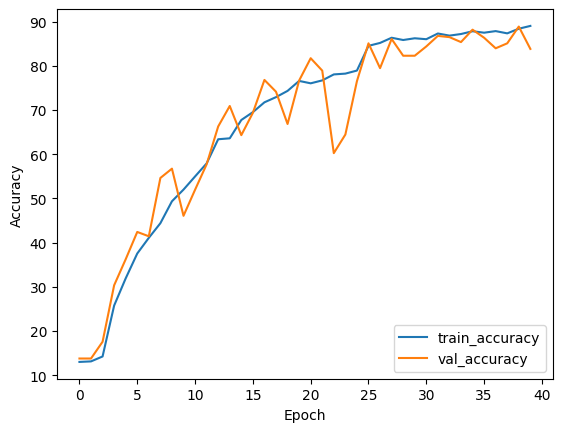

In [30]:
#Plotting the training and validation accuracy:¶
%matplotlib inline
plt.figure()
plt.plot(train_accuracy_list, label='train_accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

## **Plotting the confusion matrix:**

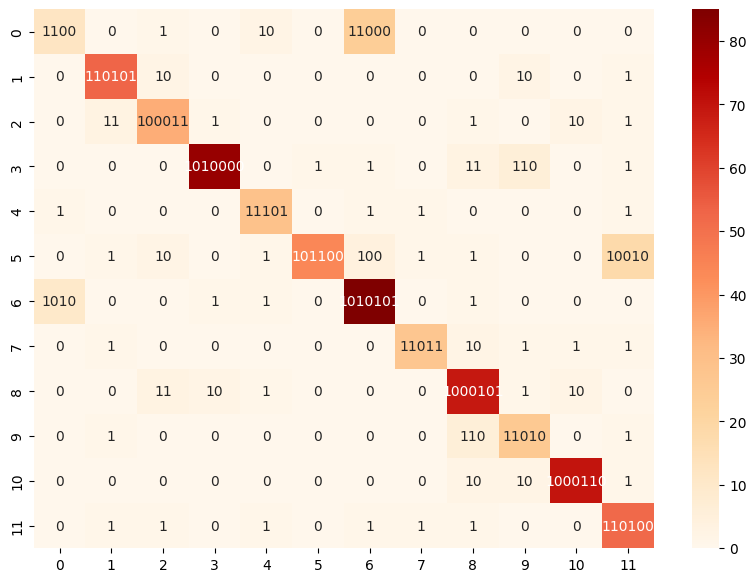

In [36]:
model1.eval()  # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Now you have true_labels and predictions
conf_mat = confusion_matrix(true_labels, predictions)

df_cm = pd.DataFrame(conf_mat, index = [i for i in range(0, 12)],
                  columns = [i for i in range(0, 12)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='b',cmap="OrRd");


## **Conclusion :**

- The model accuracy becomes constant after the 25-30th epoch.
- Reducing learning rate works well for reducing overfitting.
- Data Augmentation works as a regularizer and helps to reduce the variance in the training and increases the generalization of the model.
